Example for interaction potential 
$$
w(x-y) = \frac{1}{||x-y||^2+1}
$$

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

import scipy as sp

from tqdm import tqdm
import imageio

from utils_hf import *

from phaseportrait import PhasePortrait2D

savedir = "models/inter_pot_8gauss_moon"
os.makedirs(savedir, exist_ok=True)



In [3]:
x = sample_8gaussians(10)

In [4]:
x.shape

torch.Size([10, 2])

The dynamics for the means are linear. The dynamics of the stds are given by 
$$
\alpha'' = \int_{R^2}\frac{||z_1-z_2||^2}{(\alpha^2||z_1-z_2||^2+1)^2}d\lambda(z_1)d\lambda(z_2)
$$
with $d\lambda$ normal distributions

In [2]:
def w_p(x,y,alpha):

    return -(np.linalg.norm(x-y)**2)/((alpha**2*np.linalg.norm(x-y)**2+0.001)**2)

def f(t,x):
    samples = np.random.randn(100_000,2)
    z1 = samples[:,0]
    z2 = samples[:,1]
    return np.array([x[1],-np.mean(w_p(z1,z2,x[0]))])

def df(x,y):
    samples = np.random.randn(1_000,2)
    z1 = samples[:,0]
    z2 = samples[:,1]
    return np.array([y,-np.mean(w_p(z1,z2,x))])

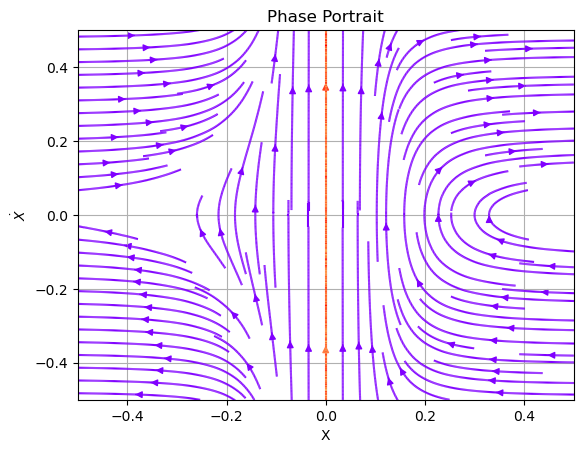

In [21]:
# example = PhasePortrait2D(df,[-.5,.5],Density=0.5)
# fig,ax = example.plot()

In [7]:
x0 = np.array([0.1,-.15])

std = sp.integrate.solve_ivp(f,[0,1],x0,t_eval = np.linspace(0,1,1000),dense_output=True)

std_f = lambda t: std.sol(t)[0]

std_prime_f = lambda t: std.sol(t)[1]


In [8]:
std_f([1])

array([0.11003129])

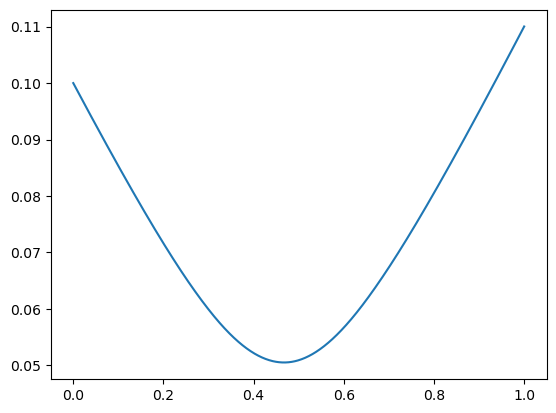

In [9]:
t = np.linspace(0,1,1000)
plt.plot(t,std_f(t))

In [10]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 20_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

In [11]:
if architecture == 'ResNet':
    model = ResNet(dim= dim,w=64,time_varying= True)
else: 
    model = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Loss: 4.554:   0%|          | 0/20000 [00:00<?, ?it/s]

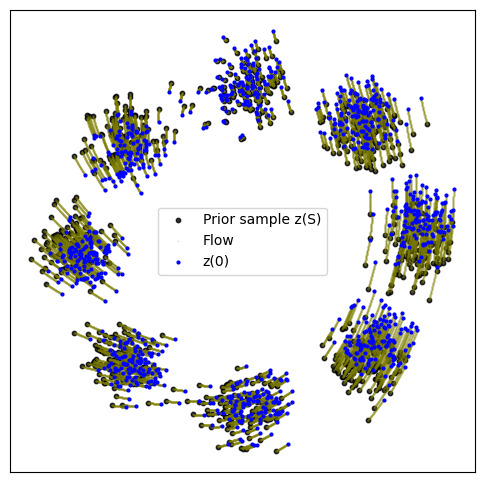

Loss: 0.265:  25%|██▌       | 5000/20000 [01:23<04:10, 59.95it/s]

<Figure size 640x480 with 0 Axes>

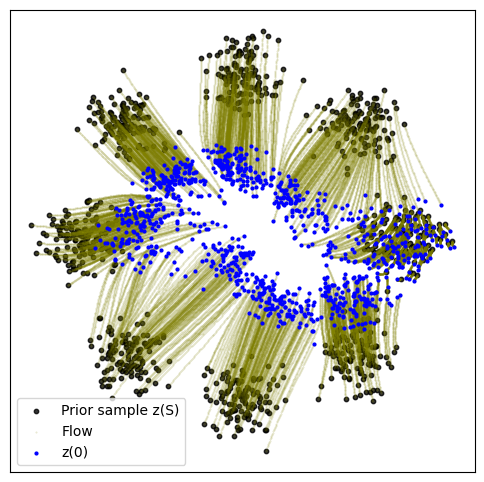

Loss: 0.118:  50%|█████     | 10000/20000 [02:46<02:45, 60.49it/s]

<Figure size 640x480 with 0 Axes>

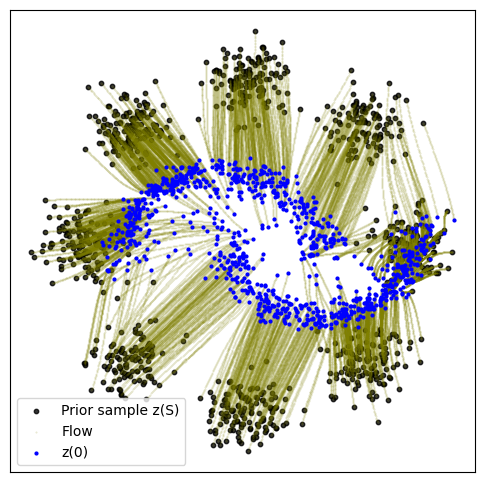

Loss: 0.096:  75%|███████▌  | 15000/20000 [04:09<01:19, 62.60it/s]

<Figure size 640x480 with 0 Axes>

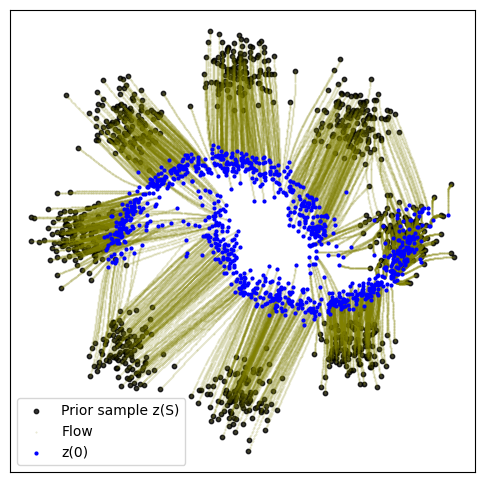

100%|██████████| 20000/20000 [05:32<00:00, 60.19it/s]0, 61.14it/s]


<Figure size 640x480 with 0 Axes>

Loss: 0.192: 100%|██████████| 20000/20000 [05:50<00:00, 61.14it/s]

In [12]:
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    # #x0 = ref_dist.sample((batch_size,))
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    # x0 = x0
    # x1 = x1
    
    mu_t = ((1-t)*x0+t*x1)
    mu_t_prime = (x1-x0)

    sig_t = torch.from_numpy(std_f(t.squeeze(-1))).float().to(x0.device).unsqueeze(-1)

    sig_t_prime = torch.from_numpy(std_prime_f(t.squeeze(-1))).float().to(x0.device).unsqueeze(-1)
    epsilon = torch.randn_like(x0)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime

    # t,xt,ut = FM.sample_location_and_conditional_flow(x0, x1)

    # print(t.shape,xt.shape,ut.shape)

    vt = model(torch.cat([xt,t],dim = -1))
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            # print(loss.item())
            traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
            plt.savefig(f"{savedir}/traj_{k}.png")


In [13]:
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [101]:
torch.save(model.state_dict(), os.path.join(savedir, f"interaction_model_{architecture}_8g_moons_20000.pt"))

In [10]:
model.load_state_dict(torch.load(os.path.join(savedir, f"interaction_model_{architecture}_8g_moons_20000.pt")))
model.eval()

MLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

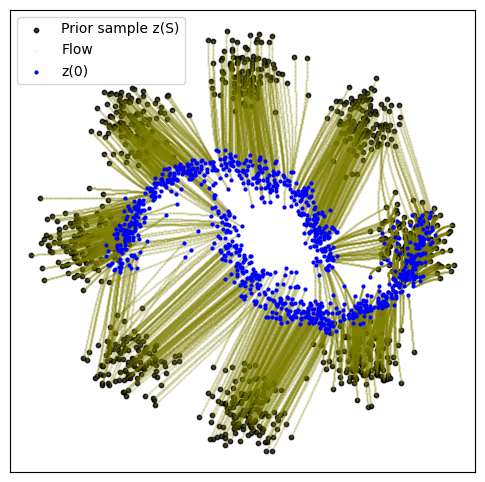

In [14]:
node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
with torch.no_grad():
    traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 150),
            )
    plt.close()
    plot_trajectories(traj.cpu().numpy())
    
#     plt.savefig(f"{savedir}/traj_final.png")

In [15]:
num_samples = 1000
xx0 = sample_8gaussians(num_samples)
gif_quiver(model,savedir,xx0,num_samples,N = 50)

In [12]:
num_samples = 1000
xx0 = sample_8gaussians(num_samples)
xx1 = sample_moons(num_samples)

particle_gif(model,savedir,xx0,xx1,N = 50)